# Prototyping Recommender Systems using AWS SageMaker

## Introduction

This is the final step in our pipe line where we used the pre-processed data for the machine learning process.The pre-processed data is stored in S3 bucket which has the data from the three sources:
* User rating data - rating.csv
* Movies titles with 20 unique genres - movies.csv
* Links to imdb - links.csv

We will use Amazon SageMaker's Factorization Machines algorithm specifically **binary classifier** method to train our model. Once our model is trained you will deploy it using Amazon SageMaker endpoint and build a simple movie recommender application using our model's endpoint.

A recommender system refers to a system that is capable of predicting the future preference of a set of items for a user, and recommend the top items. One key reason why we need a recommender system in modern society is that people have too much options to use from due to the prevalence of Internet. In the past, people used to shop in a physical store, in which the items available are limited. For instance, the number of movies that can be placed in a Blockbuster store depends on the size of that store. By contrast, nowadays, the Internet allows people to access abundant resources online. Netflix, for example, has an enormous collection of movies. Although the amount of available information increased, a new problem arose as people had a hard time selecting the items they actually want to see. This is where the recommender system comes in. 

We would be implementing the Collaborative Filtering for our analysis:
As mentioned above, Collaborative Filtering (CF) is a mean of recommendation based on users’ past behavior. There are two categories of CF: Within the collaborative filtering we are looking at the User-based CF which measures the similarity between target users and other users

Please note that this is a sample implementation by AWS and is available in AWS Samples. More details at:
https://github.com/aws-samples/aws-ml-data-lake-workshop

In [1]:
bucket = 'test-created-pranav'
prefix = 'sagemaker/movielens'
 
# Define IAM role
import boto3
import re
import seaborn as sns
from sagemaker import get_execution_role
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
%matplotlib inline

role = get_execution_role()

In [2]:
# Accessing the S3 bucket
client = boto3.client('s3') 

In [3]:
# Reading the ratings data from AWS S3 bucket
obj = client.get_object(Bucket='test-created-pranav', Key='ml/trainingdata/rating/part-00000-04633078-abbb-4c82-8338-f052d2b7e1c9-c000.csv')
ratings = pd.read_csv(obj['Body'])
# Reading the movies data from AWS S3 bucket
obj = client.get_object(Bucket='test-created-pranav', Key='ml/trainingdata/movies/part-00000-7a1095ff-a611-4c36-8328-19c3891c8e6c-c000.csv')
movies = pd.read_csv(obj['Body'])
# Reading the links data from AWS s3 bucket
obj = client.get_object(Bucket='test-created-pranav', Key='ml/trainingdata/links/part-00000-b7a7e445-066e-4f35-9893-ad03d2829f78-c000.csv')
links = pd.read_csv(obj['Body'])

In [4]:
print('The rows processed from the ratings table are {0}'.format(ratings.shape[0]))

The rows processed from the ratings table are 111048


## Data Exploration and preparation

In [5]:
movies.sample(5)

,movieid,title,genres
6900,58293,"10,000 BC (2008)",Adventure|Romance|Thriller
8703,115664,The Book of Life (2014),Adventure|Animation|Romance
2812,3520,How to Stuff a Wild Bikini (1965),Comedy
4933,7012,Mr. Destiny (1990),Comedy|Fantasy
1287,1616,"Peacemaker, The (1997)",Action|Thriller|War


In [6]:
ratings.sample(5)

,userid,movieid,rating,timestamp_c
86142,521,1372,4.0,1370072123
26321,84,68157,3.5,1429910829
93500,562,380,4.0,1167428721
7143,20,1136,4.5,1224043119
87988,533,2011,3.0,965315141


In [7]:
links.sample(5)

,movieid,imdbid,tmdbid
2154,2692,130827,104.0
8313,102252,84671,19156.0
402,453,106941,9024.0
5755,26199,64002,5638.0
2545,3166,96978,47070.0


### OneHotEncoding

In [8]:
genres_raw = list(movies['genres'])

In [9]:
genres_cooked = [x.split('|') for x in genres_raw]

In [10]:
genres_cooked[:10]

[['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy'],
 ['Adventure', 'Children', 'Fantasy'],
 ['Comedy', 'Romance'],
 ['Comedy', 'Drama', 'Romance'],
 ['Comedy'],
 ['Action', 'Crime', 'Thriller'],
 ['Comedy', 'Romance'],
 ['Adventure', 'Children'],
 ['Action'],
 ['Action', 'Adventure', 'Thriller']]

In [11]:
mlb = MultiLabelBinarizer()

In [12]:
oneHotEncoded = mlb.fit_transform(genres_cooked)

In [13]:
oneHotEncoded = pd.DataFrame(oneHotEncoded)
oneHotEncoded.sample(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
8515,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
6282,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
7000,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0
2275,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
8737,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0
2269,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4756,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3467,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2544,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2321,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [14]:
newDf = pd.concat(axis=1, objs=(movies, oneHotEncoded))

In [15]:
newDf.drop(columns=['genres'], inplace=True)

In [16]:
newDf.head(10)

,movieid,title,0,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,6,Heat (1995),0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
6,7,Sabrina (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
7,8,Tom and Huck (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,9,Sudden Death (1995),0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,10,GoldenEye (1995),0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [17]:
ratings.drop(columns=['timestamp_c'], inplace=True)

In [18]:
ratings.sample(5)

,userid,movieid,rating
54684,311,1088,5.0
13263,37,940,3.0
97383,577,3101,4.0
53682,306,1186,4.0
61774,373,2395,5.0


In [19]:
#Removing the movies from the analysis which don't have any ratings
ratedMovieIDs = list(ratings.movieid.unique())

In [20]:
#Checking for movies with missing ratings
print("Total unrated movies: {}".format(len(movies['movieid'])-len(ratedMovieIDs)))

Total unrated movies: 107


In [21]:
# That is the inconsistency. We need to 
# remove excess amount of movies.

In [22]:
# Our latest developed dataframe is newDf, so 
# we'll be using that instead of movies DF
newDf = newDf[newDf['movieid'].isin(ratedMovieIDs)]

In [23]:
len(newDf['movieid']), len(ratedMovieIDs)
# Now we see that the length of newDf['movieId'], 
# and the length of rated movies. Both should 
# be the same.

(9018, 9018)

In [24]:
nbUsers = ratings['userid'].max()
nbMovies = ratings['movieid'].max()
# Adding 20 because of appending one-hot-encoded genre 
# features too, and 2 for IMDB and TMDB IDs.
nbFeatures = nbUsers + nbMovies + 20
print("Number of Users: %d" % nbUsers)
print("Number of Movies: %d" % nbMovies)
print("Number of Features: %d" % nbFeatures)

Number of Users: 671
Number of Movies: 163949
Number of Features: 164640


## Graphs

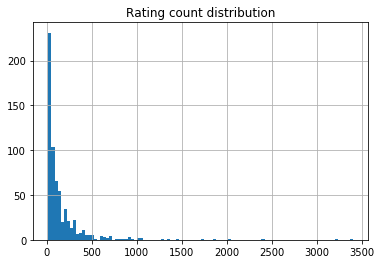

In [25]:
# Movie rating count by number of users
movies_by_user = ratings.groupby('userid')
res = movies_by_user['movieid'].count().hist(bins=100)
res.set_title('Rating count distribution')
res

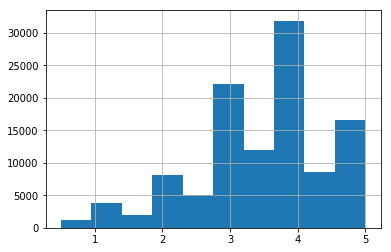

In [26]:
# From the ratings histogram it is evident that most of the ratings are around 4
ratings['rating'].hist()

In [27]:
import csv
from scipy.sparse import lil_matrix

# For each user, build a list of rated movies.
# We'd need this to add random negative samples.
moviesByUser = {}
for userId in range(nbUsers):
    moviesByUser[str(userId)] = []

for (userId, movieId, rating) in ratings.values:
    moviesByUser[str(int(userId) - 1)].append(int(movieId) - 1)

### Binary recommender

We’re going to build a binary recommender (that is, like/don’t like). 2.5 star or greater ratings are set to 1. Lower ratings are set to 0. Other than that, we'll also append the one-hot-encoded genre vectors at the end of each input vector.

In [28]:
def loadDataset(dataframe, lines, columns):
    # Features are one-hot encoded in a sparse matrix
    X = lil_matrix((lines, columns)).astype('float32')
    # Labels are stored in a vector
    Y = []
    line = 0
    # The below for-loop ferforms one-hot-encoding on the userIDs, and movieIDs
    for (userid, movieid, rating) in dataframe.values:
        ohe = (newDf[newDf.movieid == movieid][list(range(20))].values)[0]
        X[line, int(userid) - 1] = 1
        X[line, int(nbUsers) + int(movieid)-1] = 1
        # This inner loop iteratively adds the one-hot-encoded 
        # genres to the input sparse matrix. 20, because the 
        # number of genres. Each genre makes up one column.
        for i in range(20):
            X[line, int(columns)-20+(i)] = ohe[i]
        if int(rating) >= 2.5:
            Y.append(1)
        else:
            Y.append(0)
        line = line + 1
            
    Y = np.array(Y).astype('float32')
    return X, Y

In [29]:
%%time

nbRatingsTrain = len(ratings)
X_train, y_train = loadDataset(ratings, nbRatingsTrain, nbFeatures)

CPU times: user 2min 28s, sys: 1.19 s, total: 2min 29s
Wall time: 2min 27s


In [30]:
X_test = X_train[-500:]
y_test = y_train[-500:]

In [31]:
print('The rows and columns for the train are {0} and {1}'.format(X_train.shape[0],X_train.shape[1]))
print('The rows and columns for the test are {0} and {1}'.format(X_test.shape[0],X_test.shape[1]))

The rows and columns for the train are 111048 and 164640
The rows and columns for the test are 500 and 164640


In [32]:
# Specifying the locations on the S3 bucket where train, test, and outputs will be uploaded
train_key      = 'train.protobuf'
train_prefix   = '{}/{}'.format(prefix, 'train')

test_key       = 'test.protobuf'
test_prefix    = '{}/{}'.format(prefix, 'test')

output_location  = 's3://{}/{}/output'.format(bucket, prefix)

## Upload training data
Now that we've prepared our data, we'll need to convert it into recordIO-wrapped protobuf and upload it to S3 for Amazon SageMaker.

In [33]:
import sagemaker.amazon.common as smac
import io

def writeDatasetToProtobuf(X, Y, bucket, prefix, key):
    buf = io.BytesIO()
    smac.write_spmatrix_to_sparse_tensor(buf, X, Y)
    buf.seek(0)
    obj = '{}/{}'.format(prefix, key)
    boto3.resource('s3').Bucket(bucket).Object(obj).upload_fileobj(buf)
    return 's3://{}/{}'.format(bucket,obj)
    
train_data = writeDatasetToProtobuf(X_train, y_train, bucket, train_prefix, train_key)    
test_data  = writeDatasetToProtobuf(X_test, y_test, bucket, test_prefix, test_key)    

print('uploaded training data location: {}'.format(train_data))
print('uploaded test data location: {}'.format(test_data))
print('training artifacts will be uploaded to: {}'.format(output_location))

uploaded training data location: s3://test-created-pranav/sagemaker/movielens/train/train.protobuf
uploaded test data location: s3://test-created-pranav/sagemaker/movielens/test/test.protobuf
training artifacts will be uploaded to: s3://test-created-pranav/sagemaker/movielens/output


## Training the factorization machine model

Once we have the data preprocessed and available in the correct format for training, the next step is to actually train the model using the data. 

We'll use the Amazon SageMaker Python SDK to kick off training and monitor status until it is completed. 

In [34]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'factorization-machines')



Next we'll kick off the base estimator, making sure to pass in the necessary hyperparameters. Notice:

* Feature_dim is set to the total number of features, which is 2625.

* Predictor_type is set to 'binary_classifier' since we are trying to predict whether the user will like this movie or not.

* Mini_batch_size is set to 1000. This value can be tuned for relatively minor improvements in fit and speed, but selecting a reasonable value relative to the dataset is appropriate in most cases.

* Num_factors is set to 64. As mentioned initially, factorization machines find a lower dimensional representation of the interactions for all features. Making this value smaller provides a more parsimonious model, closer to a linear model, but may sacrifice information about interactions. Making it larger provides a higher-dimensional representation of feature interactions, but adds computational complexity and can lead to overfitting. In a practical application, time should be invested to tune this parameter to the appropriate value.

* Epochs is set to 100, which is the number of training epochs to run. An epoch is a measure of the number of times all of the training vectors are used once to update the weights.

In [35]:
import sagemaker

sess = sagemaker.Session()

fm = sagemaker.estimator.Estimator(container,
                                   role, 
                                   train_instance_count=1, 
                                   train_instance_type='ml.c5.xlarge',
                                   output_path=output_location,
                                   sagemaker_session=sess)

fm.set_hyperparameters(feature_dim=nbFeatures,
                      predictor_type='binary_classifier',
                      mini_batch_size=1000,
                      num_factors=64,
                      epochs=100)

fm.fit({'train': train_data, 'test': test_data})

INFO:sagemaker:Creating training-job with name: factorization-machines-2018-12-11-00-27-02-679


2018-12-11 00:27:02 Starting - Starting the training job...
2018-12-11 00:27:04 Starting - Launching requested ML instances......
2018-12-11 00:28:09 Starting - Preparing the instances for training...
2018-12-11 00:28:51 Downloading - Downloading input data
2018-12-11 00:28:51 Training - Downloading the training image...
2018-12-11 00:29:22 Training - Training image download completed. Training in progress.
Docker entrypoint called with argument(s): train
[12/11/2018 00:29:23 INFO 139676227295040] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'factors_lr': u'0.0001', u'linear_init_sigma': u'0.01', u'epochs': 1, u'_wd': u'1.0', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'factors_init_sigma': u'0.001', u'_log_level': u'info', u'bias_init_method': u'normal', u'linear_init_method': u'normal', u'linear_lr': u'0.001', u'factors_init_method': u'normal', u'_tuning_objective_metric': u'', u'bias_wd': u'0.01', u'use_l

Once training and validation is complete, you can actually see our model accuracy in the training output - **binary_classification_accuracy**. The accuracy is above 80%

## Set up hosting for the model

Now that we've trained our model, we can deploy it behind an Amazon SageMaker real-time hosted endpoint. This will allow out to make predictions (or inference) from the model dyanamically.


In [36]:
fm_predictor = fm.deploy(initial_instance_count=1,
                         instance_type='ml.c5.xlarge')

INFO:sagemaker:Creating model with name: factorization-machines-2018-12-11-00-31-15-346
INFO:sagemaker:Creating endpoint with name factorization-machines-2018-12-11-00-27-02-679


---------------------------------------------------------------!

## Model Application - Movie Recommender

To use our model, we can pass HTTP POST requests to the endpoint to get back predictions. However, to make this easier, we'll again use the Amazon SageMaker Python SDK and specify how to serialize requests and deserialize responses that are specific to the algorithm.

Since factorization machines are so frequently used with sparse data, making inference requests with a CSV format (as is done in other algorithm examples) can be massively inefficient. Rather than waste space and time generating all of those zeros, to pad the row to the correct dimensionality, JSON can be used more efficiently.

Nevertheless, we'll write our own small function to serialize our inference request in the JSON format that Amazon SageMaker Factorization Machines expects.

In [37]:
import json
from sagemaker.predictor import json_deserializer

def fm_serializer(data):
    js = {'instances': []}
    for row in data:
        js['instances'].append({'features': row.tolist()})
    return json.dumps(js)

fm_predictor.content_type = 'application/json'
fm_predictor.serializer = fm_serializer
fm_predictor.deserializer = json_deserializer

### Nearest Neighbors

Let's implement a pair-wise comparison matrix which indexes the sparse dataset, so that for every given vector, we can get the top 10 most similar sparce vectors. Once the similar vecors are obtained, a binary classification **(Inference Call)** will be performed on them to figure out the final movie recommendations.

In [38]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=10)

In [39]:
%%time

# Selecting close to 1/5th of the ratings data for the analysis
knn.fit(X_train[0:20000].toarray())

CPU times: user 5min 47s, sys: 12.1 s, total: 5min 59s
Wall time: 5min 59s


NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=10, p=2, radius=1.0)

### Application Interface


In [40]:
from IPython.core import *
import ipywidgets as widgets
from ipywidgets import HBox, VBox
from collections import OrderedDict
from IPython.display import Javascript
from IPython.display import display

In [41]:
sortedMovies = list(newDf['title'].sort_values())

In [42]:
def run_all(ev):
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index(), IPython.notebook.get_selected_index()+2)'))

* Kindly note that the drop down menu for movie lags 3 to 5 secs
* Remote to click on the ***recommend*** button
* Scroll down to see our movie recommendations

Please note that the recommender here works only for few movies as the similarity is computed for the part of the training data set. There is a chance the movies may not appear in the train data at all

In [43]:
# The code will create 'n' number of dropdowns for the user to input the watched movies
n = 0
while n < 1:    
    n = int(input("Enter a non-zero number of movies to select: "))
    
dropDownList = []
for i in range(n):
    dropDownList.append(widgets.Dropdown(options=sortedMovies, description="Movie: "+str(i+1), disabled=False))

    
Button = widgets.Button(description="Recommend")
Button.on_click(run_all)
display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index(), IPython.notebook.get_selected_index()+1)'))
    
VBox(dropDownList)



Enter a non-zero number of movies to select: 3


<IPython.core.display.Javascript object>

In [46]:
Button

<IPython.core.display.Javascript object>

Button(description='Recommend', style=ButtonStyle())

In [47]:
def recommend():
    userIDs = [672]*n
    userRatings = [5]*n
    movieIDs = []

    for mn in movieNames:
        movieIDs.append(int(newDf.movieid[newDf['title'] == mn]))
        
    tempDf = pd.DataFrame(
        OrderedDict({
            'userid': userIDs,
            'movieid': movieIDs,
            'rating': userRatings
        })
    )
    
    tempDf = tempDf[['userid', 'movieid', 'rating']]
    
    X, y = loadDataset(tempDf, len(tempDf), nbFeatures)

    recommendationIndexes = []
    for x in X.toarray():
        recommendationIndexes.append(knn.kneighbors([x], return_distance=False))

    recommendationIndexes = np.array(recommendationIndexes).flatten()

    recommendationIDs = []
    for i in recommendationIndexes:
        row = X_train[i].toarray()
        ii = np.where(row[0] == 1)[0]
        recommendationIDs.append(ii[1]+1-nbUsers)
    finalMovies = set(recommendationIDs)- set(list(tempDf['movieid']))
    #print(finalMovies)
   
    uIDs = [672]*len(finalMovies)
    rts = [5]*len(finalMovies)
    mIDs = list(finalMovies)

    finalDf = pd.DataFrame(
        {
            'userid': uIDs,
            'movieid': mIDs,
            'rating': rts
        }
    )

    finalDf = finalDf[['userid', 'movieid', 'rating']]

    finalX, finaly = loadDataset(finalDf, len(finalDf), nbFeatures)

    predictions = []
    for array in np.array_split(finalX[0:6].toarray(), 1):
        result = fm_predictor.predict(array)
    
        predictions += [r['predicted_label'] for r in result['predictions']]

    predictions = np.array(predictions)
    
    filteredMovies = []
    for p in range(len(predictions)):
        if predictions[p] > 0:
            filteredMovies.append(finalDf['movieid'].iloc[p])

    if (len(filteredMovies) < 1):
        print("No movies to recommend with that watch history")
        return 0
    else:        
        #print(links.head(5))
        recommendedMovieLinks = []
        recommendedMovies = []
        #print("filter movies : ",filteredMovies)
        for i in filteredMovies:
            recommendedMovies.append(list(newDf.title[newDf['movieid'] == i]))
            recommendedMovieLinks.append(list(links.imdbid[links['movieid'] == i]))
            #print("i : ",i)
        #print("movies link : ",recommendedMovieLinks)
        for i in range(len(recommendedMovieLinks)):
            #print("below i : ",i)
            recommendedMovieLinks[i][0] = 'https://www.imdb.com/title/tt'+str(recommendedMovieLinks[i][0]).zfill(7)+'/'

        recommendations_links = pd.DataFrame(
            {
                'Title': recommendedMovies,
                'Link': recommendedMovieLinks
            }
        )
        recommendations_links = recommendations_links[['Title', 'Link']]
        recommendedMovies = recommendations_links['Title'].values
        recommendedLinks = recommendations_links['Link'].values
        for i in range(len(recommendedMovies)):
            recommendedMovies[i] = recommendedMovies[i][0]
            recommendedLinks[i] = recommendedLinks[i][0]
        return pd.DataFrame(
            OrderedDict({
                'Title': recommendedMovies,
                'Link': recommendedLinks
            })
        )

def make_clickable(val):
    return '<a href="{}">{}</a>'.format(val,val)
        
movieNames = []
for dd in dropDownList:
    movieNames.append(dd.value)
recLinks = recommend()

try:
    recLinks.set_index('Title', inplace=True)
except:
    print("No movies for the given watch-history could be recommended")

recLinks.style.format(make_clickable)


,Link
Title,
Double Jeopardy (1999),https://www.imdb.com/title/tt0150377/
Taken 2 (2012),https://www.imdb.com/title/tt1397280/
Léon: The Professional (a.k.a. The Professional) (Léon) (1994),https://www.imdb.com/title/tt0110413/
Fight Club (1999),https://www.imdb.com/title/tt0137523/


## Clean up

In [48]:
# This is important, because we don't want any stray EC2 instance running even after our work is done.
import sagemaker

sagemaker.Session().delete_endpoint(fm_predictor.endpoint)

INFO:sagemaker:Deleting endpoint with name: factorization-machines-2018-12-11-00-27-02-679
